# Calculation of the task

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import datetime

In [2]:
def moving_of_shutter(position, time_delta):
    # used during evaporation
    # this function takes array of positions and array of times on each position
    # moves to position, than waits for the time on this position
    # shows progress
  
    for i, pos in enumerate(position):

        device.set_position(pos) 
        
        print('step ', i,'/', len(position),'   position', pos, ',um ', 'time delay', round(time_delta[i],2), ',s')
        time_left = sum(time_delta) - sum(time_delta[:i+1])
        print('    left min', time_left//60, '    left sec',round(time_left - (time_left//60) * 60, 1) )
            
        time.sleep(time_delta[i])
    


def not_evaporator_shutter_movement(to_position, dt = 1, step = 2, progress = True):
    # funktion used for not evaporation movement of the shutter
    # takes neaded end position of the shutter, 
    # time delta - how long to stay on etch transitional position, 
    # step - step between transitional positions
    # progress - can show progress, if nessesary
    #
    # during movement calculates how much time it takes to make movement (time of the loop)
    
    
    to_position = int(to_position)
    current_pos = round(device.get_position())
    
    if current_pos > to_position:
        position = range(current_pos,to_position, -step)
    elif current_pos < to_position:
        position = range(current_pos,to_position, step)
    else:
        position = [current_pos, to_position]
    
    time_delta = np.ones(len(position))*dt
    times = [] 

  
    for i, pos in enumerate(position):
        #print(pos)
        a = time.monotonic() 
        device.set_position(pos)
        
        if progress == True:
            print('step ', i, '   position', pos, ',um ', 'time delay', time_delta[i], ',s')
            print('    left seconds', sum(time_delta) - sum(time_delta[:i+1]))
            
        time.sleep(time_delta[i])

        b = time.monotonic()
        times.append(b-a)


    delay = np.mean(times)-dt
    
    device.set_position(to_position)
    
    return delay


def redusing_time_delta_by_delay_time(patch_position, patch_thicknesses, time_delta, delay):
    
    # function reduses positions, in wich time of delay less than time of the loop, 
    # in order to exclude unnesesary delays
    
    
    new_pos = []
    new_patch_thickness = []
    new_ts_delta = []
    
    for i, td in enumerate(time_delta):
        
        if td >= 0.85:
            
            new_pos.append(patch_position[i]) 
            new_patch_thickness.append(patch_thicknesses[i])
            new_ts_delta.append(round(time_delta[i] - delay,2))

        
    return new_pos, new_patch_thickness, new_ts_delta


def shutter_pre_movement():
    # from current to 0, (it can be a bit shifted from 0)
    # from 0 to 50, from 50 to 0 again
    print('in progress...')
    not_evaporator_shutter_movement(0, dt = 1, step = 2, progress = False)
    not_evaporator_shutter_movement(50, dt = 1, step = 5, progress = False)
    not_evaporator_shutter_movement(0, dt = 1, step = 5, progress = False)
    print('done')
    
    
def pre_evaporation(patch_position, patch_thicknesses, ts_delta, delay):
    
    # Now we remove steps time delta == 0s and reduse all others by loop time 
    pp, pt, tsd = redusing_time_delta_by_delay_time(patch_position, patch_thicknesses, 
                                                    ts_delta, delay)
    
    # Moving shutter to start evapor position
    _ = not_evaporator_shutter_movement(pp[0], dt = 1, step = 2, progress = True)
    
    return pp, pt, tsd

def evaporation(pp, pt, tsd):
    
    # Me1 evaporation

    moving_of_shutter(pp, tsd)
    
    
def equation(x1,y1,x2,y2):
    
    k = (y1 - y2) / (x1 - x2)
    b = y2 - k * x2

    print('y = k*x + b ')
    
    x = -b/k
    print('start position', int(x), 'um')
    print('stop position', int(Me1_end_pos_apperture_left_end), 'um')
    print('tg = shutter moving rate ', round(k,2), 'um/s')
    print('time of evaporation ', round(thickness_right/evap_rate,2), 's')
    return round(x,1), round(k,2)


def position_time_calc(patch_position,patch_thicknesses):
    time_steps = []
    time_steps_delta = []
    
    f = open('Me1.csv','w')
    
    print('position',  ' ', 'time, min:s ', 'time delta for labview,s')
    
    for i in range(len(patch_position)):
        time = patch_thicknesses[i]/evap_rate
        
        if len(time_steps)>1:
            
            time_delta = time - time_steps[-1]
        else:
            time_delta = time
        
        
        time_steps.append(time)
        time_steps_delta.append(round(time_delta,2))
        
        f.write(str(patch_position[i]))
        f.write(',')
        f.write(str(time))
        f.write(',')
        f.write(str(time_delta))
        f.write('\n')
    
        print(patch_position[i], '       ', time//60, ':', round(time - 60*(time//60),2), '        ',  round(time_delta,2))
    
        
    
    f.close()
    return time_steps_delta




import simpleaudio as sa

def sound(x,z):
    frequency = x # Our played note will be 440 Hz
    fs = 44100  # 44100 samples per second
    seconds = z  # Note duration of 3 seconds

     # Generate array with seconds*sample_rate steps, ranging between 0 and seconds
    t = np.linspace(0, seconds, int(seconds * fs), False)

    # Generate a 440 Hz sine wave
    note = np.sin(frequency * t * 2 * np.pi)

    # Ensure that highest value is in 16-bit range
    audio = note * (2**15 - 1) / np.max(np.abs(note))
    # Convert to 16-bit data
    audio = audio.astype(np.int16)

    # Start playback
    play_obj = sa.play_buffer(audio, 1, 2, fs)

     # Wait for playback to finish before exiting
    play_obj.wait_done()


def log_time(time = datetime.datetime.now(), name ='time'):
    log_file_name = 'Olga_test_' + str(datetime.datetime.today().strftime('%y%m%d') + '_')
    
    f = open(log_file_name+'.csv','a')

    f.write(str(name))
    f.write(', ')
    f.write(str(time))

    f.write('\n')
    f.close()

# Task parametrs

In [3]:


# Here Svetlanas task 
# diametr of the nanoparticles is 150nm step between centrs is 2.5 um
# 2 metals Au and Pd 

# with Au set of thicknesses from 0 A to 300 A:


patch_thicknesses = [0.0, 0.7, 1.4, 2.0, 2.7, 3.4, 4.1, 4.8, 5.5, 6.2, 
                     6.9, 7.6, 8.3, 9.0, 9.7, 10.5, 11.2, 11.9, 12.6, 
                     13.4, 14.1, 14.9, 15.6, 16.4, 17.1, 17.9, 18.6, 
                     19.4, 20.2, 21.0, 21.8, 22.5, 23.3, 24.2, 25.0, 25.8, 26.6, 27.4, 28.3, 29.1, 30.0]

''' 

patch_thicknesses = [0.0, 0.7, 1.4, 2.0, 2.7, 3.4, 4.1, 4.8, 5.5, 6.2, 
                     6.9, 7.6, 8.3, 9.0, 9.7, 10.5, 11.2, 11.9, 12.6, 
                     13.4, 14.1, 14.9, 15.6, 16.4, 17.1, 17.9, 18.6, 
                     19.4, 20.2, 21.0, 21.8, 22.5, 23.3, 24.2, 25.0, 26.6, 28.3, 30.0] # removed ,25.8, 27.4, 29.1, 
'''

#Me param
thickness_left = 0 #nm
thickness_right = 30 #nm


#pattern parametrs
step_between_different_thickneses = 2.5 #um
disk_size = 150 #nm


step = step_between_different_thickneses
evapor_length = step_between_different_thickneses*(len(patch_thicknesses)-1) #um



# Hardwer parameters

In [4]:
#apperture parametrs
apperture = 116 #um


#shutter parametrs 
shutter_pos_start = 150.0 #um



# movement parametrs
shutter_step = 0.4 #um
_limit = 280


#evaporation rate
evap_rate = 0.1 #nm/s 


# Pre calculation

In [5]:
# calculation of the position of the etch nanoparticles row

patch_position = [shutter_pos_start]


for thickness in patch_thicknesses:

    patch_position.append(patch_position[-1] + step)
    
patch_position = patch_position[:-1]

In [6]:
patch_position[-1] - 150

100.0

In [7]:
len(patch_position)

41

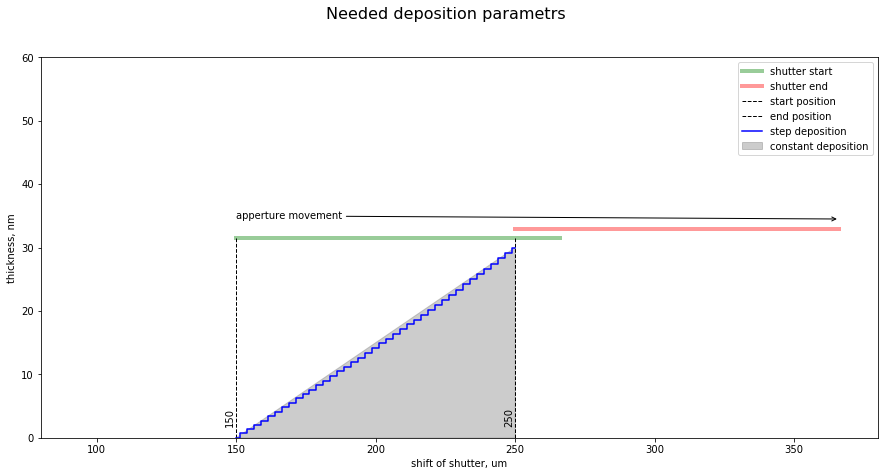

In [8]:
# Check that it's possible to fit

Me1_start_pos_apperture_left_end = shutter_pos_start 
Me1_start_pos_apperture_right_end = shutter_pos_start + apperture 

Me1_end_pos_apperture_left_end = shutter_pos_start + evapor_length  
Me1_end_pos_apperture_right_end = shutter_pos_start + apperture + evapor_length  


Me2_start_pos_apperture_right_end = Me1_end_pos_apperture_left_end
Me2_start_pos_apperture_left_end = Me1_end_pos_apperture_left_end - apperture

Me2_end_pos_apperture_left_end = Me1_end_pos_apperture_left_end - apperture - evapor_length  
Me2_end_pos_apperture_right_end = Me1_end_pos_apperture_left_end - evapor_length



fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

#apperture Me1
plt.plot([Me1_start_pos_apperture_left_end,Me1_start_pos_apperture_right_end], 
         [thickness_right*1.05,thickness_right*1.05], 
         linewidth=4.0, c = 'green', alpha = 0.4)

plt.plot([Me1_end_pos_apperture_left_end,Me1_end_pos_apperture_right_end], 
         [thickness_right*1.1,thickness_right*1.1], 
         linewidth=4.0, c = 'r', alpha = 0.4)
''' 
#apperture Me2
plt.plot([Me2_start_pos_apperture_right_end,Me2_start_pos_apperture_left_end], 
         [thickness_right*1.2,thickness_right*1.2], 
         linewidth=4.0, c = 'red', alpha = 0.4)

plt.plot([Me2_end_pos_apperture_left_end,Me2_end_pos_apperture_right_end], 
         [thickness_right*1.25,thickness_right*1.25], 
         linewidth=4.0, c = 'red', alpha = 0.4)
'''
#apperture limits

plt.plot([Me1_end_pos_apperture_left_end,Me1_end_pos_apperture_left_end], 
         [thickness_right*1.05,0], '--',
         linewidth=1,  c = 'k', alpha = 1)

plt.plot([Me1_start_pos_apperture_left_end,Me1_start_pos_apperture_left_end], 
         [thickness_right*1.05,0], '--',
         linewidth=1, c = 'k', alpha = 1)
 
plt.text(Me1_end_pos_apperture_left_end -4, 2, str(int(Me1_end_pos_apperture_left_end)), rotation='vertical',)
plt.text(Me1_start_pos_apperture_left_end -4, 2, str(int(Me1_start_pos_apperture_left_end)), rotation='vertical',)


    
#deposition
# Trapez first Me
x = [shutter_pos_start,shutter_pos_start, shutter_pos_start+evapor_length,shutter_pos_start+evapor_length]
y = [0,thickness_left,thickness_right,0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), color = 'grey', alpha = 0.4))
''' 
# Trapez out
x = [0,0, 20,20]
y = [0,thickness_right*2,thickness_right*2,0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), edgecolor = 'b',color = 'grey', alpha = 0.3))

x = [275,275, 300,300]
y = [0,thickness_right*2,thickness_right*2,0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), edgecolor = 'b',color = 'grey', alpha = 0.3))
'''
#ME thickness from patches 
#plt.plot(patch_position, patch_thicknesses, c = 'b')
plt.step(patch_position, patch_thicknesses, where='mid', c = 'b')#, [fmt], *, data=None, where='pre', **kwargs)
#plt.step(patch_position_1, patch_thicknesses_1, where='mid', c = 'r')#, [fmt], *, data=None, where='pre', **kwargs)




plt.annotate("apperture movement", xy=(shutter_pos_start+apperture+evapor_length,thickness_right*1.15), 
             xytext=(shutter_pos_start,thickness_right*1.15), arrowprops=dict(arrowstyle="->"))


plt.suptitle('Needed deposition parametrs', fontsize=16)
plt.legend(['shutter start', 'shutter end', 'start position', 'end position', 'step deposition', 'constant deposition','shutter 2 start', 'shutter 2 end', 'limit 1', 
           'limit 2', 'from patches', 'metal'])
plt.xlabel('shift of shutter, um')
plt.ylabel('thickness, nm')
plt.xlim([80, 380])
plt.ylim([0, thickness_right*2])

#plt.xticks([0.15, 0.68, 0.97])

plt.show()

/Users/olgase/.local/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/olgase/.local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


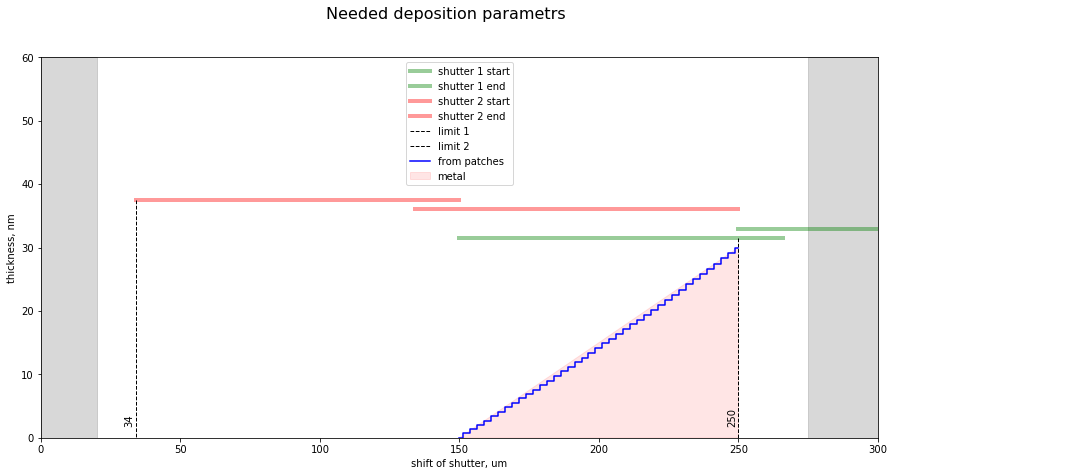

In [9]:
# Check that it's possible to fit

Me1_start_pos_apperture_left_end = shutter_pos_start 
Me1_start_pos_apperture_right_end = shutter_pos_start + apperture 

Me1_end_pos_apperture_left_end = shutter_pos_start + evapor_length  
Me1_end_pos_apperture_right_end = shutter_pos_start + apperture + evapor_length  


Me2_start_pos_apperture_right_end = Me1_end_pos_apperture_left_end
Me2_start_pos_apperture_left_end = Me1_end_pos_apperture_left_end - apperture

Me2_end_pos_apperture_left_end = Me1_end_pos_apperture_left_end - apperture - evapor_length  
Me2_end_pos_apperture_right_end = Me1_end_pos_apperture_left_end - evapor_length



fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

#apperture Me1
plt.plot([Me1_start_pos_apperture_left_end,Me1_start_pos_apperture_right_end], 
         [thickness_right*1.05,thickness_right*1.05], 
         linewidth=4.0, c = 'green', alpha = 0.4)

plt.plot([Me1_end_pos_apperture_left_end,Me1_end_pos_apperture_right_end], 
         [thickness_right*1.1,thickness_right*1.1], 
         linewidth=4.0, c = 'green', alpha = 0.4)

#apperture Me2
plt.plot([Me2_start_pos_apperture_right_end,Me2_start_pos_apperture_left_end], 
         [thickness_right*1.2,thickness_right*1.2], 
         linewidth=4.0, c = 'red', alpha = 0.4)

plt.plot([Me2_end_pos_apperture_left_end,Me2_end_pos_apperture_right_end], 
         [thickness_right*1.25,thickness_right*1.25], 
         linewidth=4.0, c = 'red', alpha = 0.4)

#apperture limits

plt.plot([Me1_end_pos_apperture_left_end,Me1_end_pos_apperture_left_end], 
         [thickness_right*1.05,0], '--',
         linewidth=1,  c = 'k', alpha = 1)

plt.plot([Me2_end_pos_apperture_left_end,Me2_end_pos_apperture_left_end], 
         [thickness_right*1.25,0], '--',
         linewidth=1, c = 'k', alpha = 1)
 
plt.text(Me1_end_pos_apperture_left_end -4, 2, str(int(Me1_end_pos_apperture_left_end)), rotation='vertical',)
plt.text(Me2_end_pos_apperture_left_end -4, 2, str(int(Me2_end_pos_apperture_left_end)), rotation='vertical',)


    
#deposition
# Trapez first Me
x = [shutter_pos_start,shutter_pos_start, shutter_pos_start+evapor_length,shutter_pos_start+evapor_length]
y = [0,thickness_left,thickness_right,0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), color = 'r', alpha = 0.1))

 
# Trapez out
x = [0,0, 20,20]
y = [0,thickness_right*2,thickness_right*2,0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), edgecolor = 'b',color = 'grey', alpha = 0.3))

x = [275,275, 300,300]
y = [0,thickness_right*2,thickness_right*2,0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), edgecolor = 'b',color = 'grey', alpha = 0.3))

#ME thickness from patches 
#plt.plot(patch_position, patch_thicknesses, c = 'b')
plt.step(patch_position, patch_thicknesses, where='mid', c = 'b')#, [fmt], *, data=None, where='pre', **kwargs)
#plt.step(patch_position_1, patch_thicknesses_1, where='mid', c = 'r')#, [fmt], *, data=None, where='pre', **kwargs)




plt.annotate("apperture movement", xy=(shutter_pos_start+apperture+evapor_length,thickness_right*1.15), 
             xytext=(shutter_pos_start,thickness_right*1.15), arrowprops=dict(arrowstyle="->"))


plt.suptitle('Needed deposition parametrs', fontsize=16)
plt.legend(['shutter 1 start', 'shutter 1 end', 'shutter 2 start', 'shutter 2 end', 'limit 1', 
           'limit 2', 'from patches', 'metal'])
plt.xlabel('shift of shutter, um')
plt.ylabel('thickness, nm')
plt.xlim([0, 300])
plt.ylim([0, thickness_right*2])

#plt.xticks([0.15, 0.68, 0.97])

plt.show()

#### Adjustments mostly can be done with changing aperture size
#### When all fits into left and right limit, it's time to decide what kind of evaporation will be the best: continuous or stepped


# Continuous process

In [10]:
calc_start = equation(shutter_pos_start, thickness_left, shutter_pos_start+evapor_length, thickness_right)

y = k*x + b 
start position 150 um
stop position 250 um
tg = shutter moving rate  0.3 um/s
time of evaporation  300.0 s


In [11]:
# Table every 10 sec 
# For constant moving rate 

"""  
print('Time of first Me evaporation is ' + str(thickness_right/evap_rate))
print('Shutter moving rate is ' , calc_start[1], 'um/s')
print('')

shutter_pos_start

for i in range(int(thickness_right/(evap_rate*10))+1):

        
    print(str(i*10) + '  sec shift = ' + str(shutter_pos_start + round(calc_start[1]*i*10,1)) + ' um')
"""

"  \nprint('Time of first Me evaporation is ' + str(thickness_right/evap_rate))\nprint('Shutter moving rate is ' , calc_start[1], 'um/s')\nprint('')\n\nshutter_pos_start\n\nfor i in range(int(thickness_right/(evap_rate*10))+1):\n\n        \n    print(str(i*10) + '  sec shift = ' + str(shutter_pos_start + round(calc_start[1]*i*10,1)) + ' um')\n"

# Stepped process

In [12]:
# Moving shutter to start evapor position
#_ = not_evaporator_shutter_movement(pp[0], dt = 1, step = 2, progress = False)

In [13]:
# Me 1
ts_delta_Me1 = position_time_calc(patch_position,patch_thicknesses )


position   time, min:s  time delta for labview,s
150.0         0.0 : 0.0          0.0
152.5         0.0 : 7.0          7.0
155.0         0.0 : 14.0          7.0
157.5         0.0 : 20.0          6.0
160.0         0.0 : 27.0          7.0
162.5         0.0 : 34.0          7.0
165.0         0.0 : 41.0          7.0
167.5         0.0 : 48.0          7.0
170.0         0.0 : 55.0          7.0
172.5         1.0 : 2.0          7.0
175.0         1.0 : 9.0          7.0
177.5         1.0 : 16.0          7.0
180.0         1.0 : 23.0          7.0
182.5         1.0 : 30.0          7.0
185.0         1.0 : 37.0          7.0
187.5         1.0 : 45.0          8.0
190.0         1.0 : 52.0          7.0
192.5         1.0 : 59.0          7.0
195.0         2.0 : 6.0          7.0
197.5         2.0 : 14.0          8.0
200.0         2.0 : 21.0          7.0
202.5         2.0 : 29.0          8.0
205.0         2.0 : 36.0          7.0
207.5         2.0 : 44.0          8.0
210.0         2.0 : 51.0          7.0
212.5 

In [14]:
# Me 2
patch_thicknesses_Me2 = []
patch_position_Me2 = []
sum_thicknesses = []

for i in range(len(patch_thicknesses)-1,-1, -1):
    
    Me2_thicknesses = thickness_right - patch_thicknesses[i]
    patch_thicknesses_Me2.append(Me2_thicknesses)
    patch_position_Me2.append(patch_position[i] - apperture)
    sum_thicknesses.append((patch_thicknesses[i] + Me2_thicknesses))

ts_delta_Me2 = position_time_calc(patch_position_Me2,patch_thicknesses_Me2 )

position   time, min:s  time delta for labview,s
134.0         0.0 : 0.0          0.0
131.5         0.0 : 9.0          9.0
129.0         0.0 : 17.0          8.0
126.5         0.0 : 26.0          9.0
124.0         0.0 : 34.0          8.0
121.5         0.0 : 42.0          8.0
119.0         0.0 : 50.0          8.0
116.5         0.0 : 58.0          8.0
114.0         1.0 : 7.0          9.0
111.5         1.0 : 15.0          8.0
109.0         1.0 : 22.0          7.0
106.5         1.0 : 30.0          8.0
104.0         1.0 : 38.0          8.0
101.5         1.0 : 46.0          8.0
99.0         1.0 : 54.0          8.0
96.5         2.0 : 1.0          7.0
94.0         2.0 : 9.0          8.0
91.5         2.0 : 16.0          7.0
89.0         2.0 : 24.0          8.0
86.5         2.0 : 31.0          7.0
84.0         2.0 : 39.0          8.0
81.5         2.0 : 46.0          7.0
79.0         2.0 : 54.0          8.0
76.5         3.0 : 1.0          7.0
74.0         3.0 : 8.0          7.0
71.5         3.0 : 

In [19]:
shutter_pos_start

150.0

/Users/olgase/.local/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/olgase/.local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


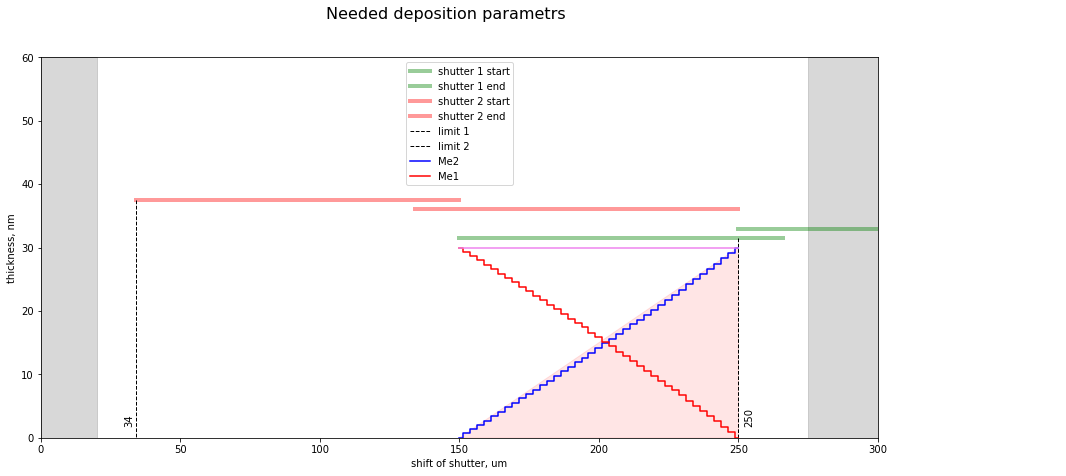

In [18]:
# Check that it's possible to fit

Me1_start_pos_apperture_left_end = shutter_pos_start 
Me1_start_pos_apperture_right_end = shutter_pos_start + apperture 

Me1_end_pos_apperture_left_end = shutter_pos_start + evapor_length  
Me1_end_pos_apperture_right_end = shutter_pos_start + apperture + evapor_length  


Me2_start_pos_apperture_right_end = Me1_end_pos_apperture_left_end
Me2_start_pos_apperture_left_end = Me1_end_pos_apperture_left_end - apperture

Me2_end_pos_apperture_left_end = Me1_end_pos_apperture_left_end - apperture - evapor_length  
Me2_end_pos_apperture_right_end = Me1_end_pos_apperture_left_end - evapor_length



fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

#apperture Me1
plt.plot([Me1_start_pos_apperture_left_end,Me1_start_pos_apperture_right_end], 
         [thickness_right*1.05,thickness_right*1.05], 
         linewidth=4.0, c = 'green', alpha = 0.4)

plt.plot([Me1_end_pos_apperture_left_end,Me1_end_pos_apperture_right_end], 
         [thickness_right*1.1,thickness_right*1.1], 
         linewidth=4.0, c = 'green', alpha = 0.4)

#apperture Me2
plt.plot([Me2_start_pos_apperture_right_end,Me2_start_pos_apperture_left_end], 
         [thickness_right*1.2,thickness_right*1.2], 
         linewidth=4.0, c = 'red', alpha = 0.4)

plt.plot([Me2_end_pos_apperture_left_end,Me2_end_pos_apperture_right_end], 
         [thickness_right*1.25,thickness_right*1.25], 
         linewidth=4.0, c = 'red', alpha = 0.4)

#apperture limits

plt.plot([Me1_end_pos_apperture_left_end,Me1_end_pos_apperture_left_end], 
         [thickness_right*1.05,0], '--',
         linewidth=1,  c = 'k', alpha = 1)

plt.plot([Me2_end_pos_apperture_left_end,Me2_end_pos_apperture_left_end], 
         [thickness_right*1.25,0], '--',
         linewidth=1, c = 'k', alpha = 1)
 
plt.text(Me1_end_pos_apperture_left_end +2, 2, str(int(Me1_end_pos_apperture_left_end)), rotation='vertical',)
plt.text(Me2_end_pos_apperture_left_end -4, 2, str(int(Me2_end_pos_apperture_left_end)), rotation='vertical',)


    
#deposition
# Trapez first Me
x = [shutter_pos_start,shutter_pos_start, shutter_pos_start+evapor_length,shutter_pos_start+evapor_length]
y = [0,thickness_left,thickness_right,0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), color = 'r', alpha = 0.1))

 
# Trapez out
x = [0,0, 20,20]
y = [0,thickness_right*2,thickness_right*2,0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), edgecolor = 'b',color = 'grey', alpha = 0.3))

x = [275,275, 300,300]
y = [0,thickness_right*2,thickness_right*2,0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), edgecolor = 'b',color = 'grey', alpha = 0.3))

#ME thickness from patches 
plt.step(patch_position, patch_thicknesses, where='mid', c = 'b')#, [fmt], *, data=None, where='pre', **kwargs)
plt.step(patch_position_Me2 +np.ones(len(patch_position_Me2))*apperture, patch_thicknesses_Me2, where='mid', c = 'r')#, [fmt], *, data=None, where='pre', **kwargs)

plt.plot(patch_position, sum_thicknesses,  c = 'violet')







plt.annotate("apperture movement", xy=(shutter_pos_start+apperture+evapor_length,thickness_right*1.15), 
             xytext=(shutter_pos_start,thickness_right*1.15), arrowprops=dict(arrowstyle="->"))


plt.suptitle('Needed deposition parametrs', fontsize=16)
plt.legend(['shutter 1 start', 'shutter 1 end', 'shutter 2 start', 'shutter 2 end', 'limit 1', 
           'limit 2', 'Me2', 'Me1'])
plt.xlabel('shift of shutter, um')
plt.ylabel('thickness, nm')
plt.xlim([0, 300])
plt.ylim([0, thickness_right*2])

#plt.xticks([0.15, 0.68, 0.97])

plt.show()
#ME thickness from patches 
#plt.plot(patch_position, patch_thicknesses, c = 'b')


